# Relationship between local precipitation and wildfire season near Santa Fe, New Mexico

## Research question: What part does average monthly precipitation play in yearly wildfire season for the Santa Fe National Forest?

This notebook uses geo-referenced wildfire data extracted from a sqlite database containing statistics from 1.88 million wildfires that can be downloaded from Kaggle.com at https://www.kaggle.com/rtatman/188-million-us-wildfires

This database is sampled to extract wildfires that occured in a 730 square mile area of the Santa Fe National Forest containing the southern region of the Sangre de Cristo mountains east of Santa Fe, New Mexico.

The precipitation data is extracted from the Natural Resource Conservation Service database that can be queried using the report generator at https://www.wcc.nrcs.usda.gov/  The precipitation CSV file is for snow adjusted total monthly precipitation observed at the Santa Fe SNOTEL site located near the Santa Fe Ski Area within the wildfire sample area. The database records observations from October 1996 to April 2018

Conclusions: The drop in precipitation during May and June results in a peak fire season for those months.  The fire season ends when monsoon rainflow causes an upsurge in precipitation for the month of July.  Other factors are involved, however, since the average acreage burned during June is less than in May even though June has less rainfall on average.  More research is required to identify those additional factors.

In [44]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import sqlite3

%matplotlib notebook

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [45]:
def query_fire_data():
    ''' 
    Read and reduce the wildfire dataset. This cell is very memory and CPU intensive. 
    It generates the file 'df_regional_SF_fires.csv'. Re-running this cell can be avoided by reading
    the file in instead.
    '''

    # Define the area to be sampled for wildfire data
    # as the region East of Sante Fe in Sangre de Cristo mountains. Approx 730 sq miles.
    # Santa Fe National Forest

    WEST_BOUNDARY = -105.85063
    EAST_BOUNDARY = -105.45575
    NORTH_BOUNDARY = 35.98787
    SOUTH_BOUNDARY = 35.51079

    sqlite_file = '.\FPA_FOD_20170508.sqlite'
    conn = sqlite3.connect(sqlite_file)
    c = conn.cursor()


    df_fires = pd.read_sql_query("SELECT * FROM fires", conn)
    df_fires = df_fires[['DISCOVERY_DATE', 'FIRE_SIZE', 'FIRE_YEAR', 
                     'FIRE_NAME', 'LATITUDE', 'LONGITUDE']]

    df_regional_SF_fires = df_fires[(df_fires['LONGITUDE'] > WEST_BOUNDARY) &
                                (df_fires['LONGITUDE'] < EAST_BOUNDARY) &
                                (df_fires['LATITUDE'] < NORTH_BOUNDARY) &
                                (df_fires['LATITUDE'] > SOUTH_BOUNDARY)]

    epoch = pd.to_datetime(0, unit='s').to_julian_date()
    sr_dates_of_fires = pd.to_datetime(df_regional_SF_fires['DISCOVERY_DATE'] - epoch, unit = 'D').rename('DATE')

    df_fire_table = pd.concat([df_regional_SF_fires, sr_dates_of_fires], axis=1)

    df_fire_table = df_fire_table[['DATE', 'FIRE_NAME', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE']]
    df_fire_table = df_fire_table.set_index('DATE')
    df_fire_table.to_csv ('df_regional_SF_fires.csv')
    conn.close()
    

In [46]:
# Uncomment the following line to re-generate the Regional Santa Fe fires CSV file
#df_fire_table = df_fire_query_fire_data()

df_fire_table = pd.read_csv('df_regional_SF_fires.csv', index_col=0, parse_dates=True)

In [47]:
dct_avg_fire_size = {}

for month in range(1,13):
    fire_mean = df_fire_table[df_fire_table.index.month == month]['FIRE_SIZE'].mean()
    dct_avg_fire_size[month] = fire_mean


In [48]:

def get_precipitation_timeseries():
    df_ts_precipitation = pd.read_csv(
            'SF TS SNOTEL - snow adjusted.csv', skiprows=55,
            names=['Date', 'Precipitation'])
    
    lst_months = []
    lst_years = []
    
    for index, row in df_ts_precipitation.iterrows():
        lst_months.append(row['Date'][:3])
        lst_years.append(row['Date'][4:])

    df_ts_precipitation['Month'] = lst_months
    df_ts_precipitation['Year'] = lst_years
    df_ts_precipitation = df_ts_precipitation[['Month',
                                               'Year',
                                               'Precipitation']]
    
    return df_ts_precipitation

def get_monthly_avg_precipitation(df_timeseries):
    dct_avg_precip = {}
    for month in MONTHS:
        precip_mean = df_timeseries[df_timeseries[
                'Month'] == month]['Precipitation'].mean()
        dct_avg_precip[MONTHS.index(month)] = precip_mean
    return dct_avg_precip


df_ts_precipitation = get_precipitation_timeseries()
dct_averages = get_monthly_avg_precipitation(df_ts_precipitation)

<IPython.core.display.Javascript object>


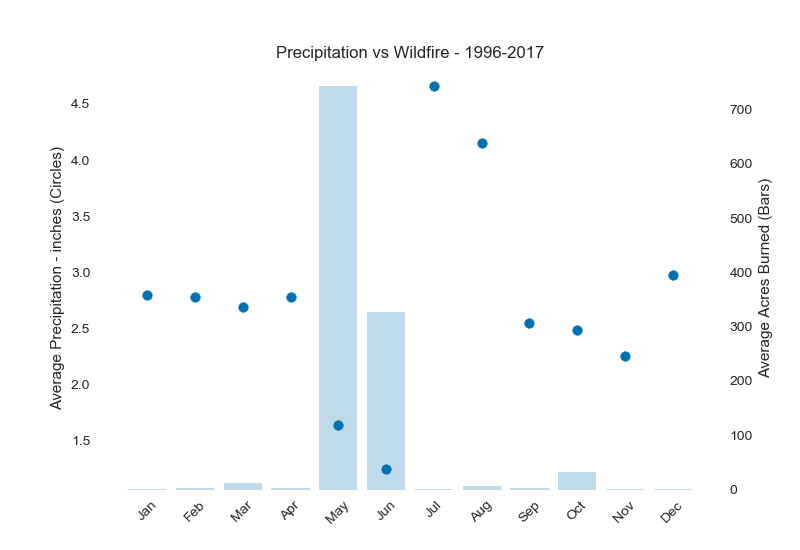

In [49]:
fig, ax1 = plt.subplots()
pltxticsk = plt.xticks(range(0,13), MONTHS, rotation=45)
plt.title('Precipitation vs Wildfire - 1996-2017')


ax1.scatter(range(0,12), dct_averages.values())
ax1.set_ylabel('Average Precipitation - inches (Circles)')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(range(0,12), dct_avg_fire_size.values(), alpha=0.25)
ax2.set_ylabel('Average Acres Burned (Bars)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
